In [214]:
import os
import math
import pandas as pd

def calculate_h_index(quotation): #h_ndex
    quotation.sort(reverse=True)  # 논문을 내림차순으로 정렬

    h_index = 0
    for i, quotation in enumerate(quotation):
        if quotation >= i + 1:
            h_index = i + 1
        else:
            break

    return h_index

def calculate_i10_index(quotation):  #i10_index
    i10_index = sum(1 for quotation in quotation if quotation >= 10)
    return i10_index

def calculate_g_index(quotation):  #g_index
    quotation.sort(reverse=True)  # 논문을 내림차순으로 정렬

    g_index = 0
    quotation_sum=0
    for i, quotation in enumerate(quotation):
        quotation_sum+=quotation
        if quotation_sum >= (i + 1)**2:
            g_index = i + 1

    return g_index

#Object 타입에서 숫자형 체크용
def is_numeric(value):
    try:
        float(value)  # float으로 변환 가능한 경우 숫자
        return True
    except (ValueError, TypeError):
        return False

def recentness(dt, pYears):
    # dt = datetime.datetime.now()#현재날짜
    rct = 0
    lct = 0
    if len(pYears) == 0:
        rct = 0
        lct = 0
    else:
        year_avg = sum(pYears) / len(pYears)
        if year_avg >= int(dt)-2: #int(dt.year)-2:
            lct = 1
        else:
            lct = max(round((1-(int(dt)-3-year_avg)*0.1),2), 0)
        # elif int(dt)-15 < year_avg <= int(dt)-3:
        #     lct = max(round((1-(int(dt)-3-year_avg)*0.1),2), 0)

        rct += len(pYears) #연도 개수

    return rct, lct

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', None)

#authors.all 파일 위치 주소
authors_file_path = r"./gsc_data/authors.all"

try:
    with open(authors_file_path, 'r', encoding='cp1252') as file:
        lines = file.read().splitlines()
        data = [line.split('|') for line in lines]
        columns = ["Valid", "Name", "Affiliation", "Email Domain", "Citation Count", "ID"]
        df_a = pd.DataFrame(data,columns=columns) # authors 의 a
        # df_a = df_a.drop(columns=["C6", "C7"])
        print("변환 완료")
except FileNotFoundError:
    print("파일을 찾을 수 없습니다.")
except UnicodeDecodeError:
    print("파일을 ANSI(Windows-1252) 인코딩으로 열 수 없습니다.")
    
df_a_copy = df_a.copy()  # df_a의 복사본 생성

for index, row in df_a_copy.iterrows():
    if pd.isna(row[5]):  
        if pd.isna(row[4]):
            if pd.isna(row[3]):  # 1의 경우
                row[5] = row[2] 
            else:  # 2,3,4 의 경우
                row[5] = row[3]
                if is_numeric(row[2]): # 4의 경우
                    row[4] = row[2]
                    row[2] = None
                    row[3] = None
                elif '.' in str(row[2]):  # 3의 경우
                    row[3] = row[2]
                    row[2] = None
                    row[4] = None
                else: # 2의 경우
                    row[3] = None
        else:  # 5,6,7 의 경우
            row[5] = row[4] 
            if is_numeric(row[3]): # 6,7 의 경우
                row[4] = row[3]
                if '.' in str(row[2]): # 7 의 경우
                    row[3] = row[2]
                    row[2] = None
                else: # 6의 경우
                    
                    row[3] = None
            else: #5의 경우
                row[4] = None

변환 완료


In [215]:
#gsc_data\DATA 폴더 경로
folder_path = r"./gsc_data/DATA/"

max_scoquality = 10560.179775735329
max_rct = 13764
max_rct1 = []
max_scoquality1 = []
max_lct = []
alpha = 0
dt = 2013

years_dict = {}

# df_a_copy의 각 행에서 1번 열의 값을 추출
for index, row in df_a_copy.iterrows():
    name = row[5]  # 1번 열의 값
   
    # 파일 경로 생성
    file_path = os.path.join(folder_path, name + "_.dat")
   
    # 파일이 존재하는지 확인
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            # 파일의 각 줄을 읽어 리스트로 저장
            lines = file.readlines()
 
        # 각 줄을 나누어서 리스트로 저장
        line_lists = [line.strip().split('|') for line in lines]
       
        #빈 리스트 생성
        citations = [] #인용수
        years = [] #연도
        scoquality = 0 #품질
        for line_list in line_lists:
            if len(line_list) > 0:
                if int(line_list[1]) >= 1993:
                    citations.append(int(line_list[0]))
                    years.append(int(line_list[1]))
                    if line_list[1] in years_dict:
                        years_dict[line_list[1]] += 1
                    else:
                        years_dict[line_list[1]] = 1
                    scoquality += math.log(int(line_list[0])*math.exp((int(line_list[1])-dt)/10)+1)
 
        sum_citations = sum(citations)
        # print(sum_citations)
        # print(name, years)
        max_scoquality1.append(scoquality)
        rct, lct = recentness(dt, years)
        max_lct.append(lct)
        max_rct1.append(rct)
        norm_scoquality = scoquality/max_scoquality
        # norm_recentness = rct/max_rct*0.66*lct
        norm_recentness = ((rct/max_rct)+lct)*0.5
        score = (norm_scoquality * alpha) + norm_recentness * (100 - alpha) 
        # print(rct, scoquality, scoquality/max_scoquality, rct/max_rct, lct, norm_recentness, score)
        #각 index 계산 후 df_a_copy에 새로운 열로 추가
        df_a_copy.at[index,"sum_citation"] = sum_citations
        df_a_copy.at[index,"Paper Count"] = len(citations)
        df_a_copy.at[index,"h-index"] = calculate_h_index(citations)
        df_a_copy.at[index,"i10-index"] = calculate_i10_index(citations)
        df_a_copy.at[index,"g-index"] = calculate_g_index(citations)
        df_a_copy.at[index,"scoquality"] = norm_scoquality
        df_a_copy.at[index,"recentness"] = norm_recentness
        df_a_copy.at[index,"score"] = score

    else:
        print(f"파일을 찾을 수 없습니다: {file_path}")
       
df_a_copy['ID'] = 'id_' + df_a_copy['ID']
 
# print(max_scoquality1)
print(max(max_scoquality1))
print(max(max_rct1))
print(max(max_lct))
 
# print(df_a_copy)
df_a_copy.head(20)
df_a_copy.to_csv('output.csv', index=False)
df_a_copy.to_csv('output_index.csv', index=True)

10560.179775735329
13764
1.1


In [216]:
import pandas as pd

# CSV 파일 경로
raw_data = 'output.csv'
df = pd.read_csv(raw_data)

#지수별로 내림차순 정렬
H_sorted=df.sort_values(by='h-index', ascending=False)
I10_sorted=df.sort_values(by='i10-index', ascending=False)
G_sorted=df.sort_values(by='g-index', ascending=False)
Citation_sorted=df.sort_values(by='Citation Count', ascending=False)
PaperC_sorted=df.sort_values(by='Paper Count', ascending=False)
scoquality_sorted=df.sort_values(by='scoquality', ascending=False)
recentness_sorted=df.sort_values(by='recentness', ascending=False)
score_sorted=df.sort_values(by='score', ascending=False)

#필요없는 컬럼 삭제
H_sorted=H_sorted.reset_index(drop=True, inplace=False)
I10_sorted=I10_sorted.reset_index(drop=True, inplace=False)
G_sorted=G_sorted.reset_index(drop=True, inplace=False)
Citation_sorted=Citation_sorted.reset_index(drop=True, inplace=False)
PaperC_sorted=PaperC_sorted.reset_index(drop=True, inplace=False)
scoquality_sorted=scoquality_sorted.reset_index(drop=True, inplace=False)
recentness_sorted=recentness_sorted.reset_index(drop=True, inplace=False)
score_sorted=score_sorted.reset_index(drop=True, inplace=False)

#지수 순위 입력
# num=int(input("숫자 입력 : "))
num=89786

#해당 순위이내의 결과만 남김
H_sorted = H_sorted.head(num)
I10_sorted = I10_sorted.head(num)
G_sorted = G_sorted.head(num)
score_sorted = score_sorted.head(num)

Citation_sorted = Citation_sorted.head(num)
PaperC_sorted = PaperC_sorted.head(num)
scoquality_sorted = scoquality_sorted.head(num)
recentness_sorted = recentness_sorted.head(num)

score_sorted.drop(columns=['Valid', 'Affiliation', 'sum_citation','h-index', 'i10-index', 'g-index', 'Citation Count','Email Domain', 'Paper Count', 'scoquality', 'recentness'], axis=1, inplace=True)
H_sorted.drop(columns=['Valid', 'Affiliation', 'sum_citation','i10-index', 'g-index', 'Citation Count','Email Domain', 'Paper Count', 'scoquality', 'recentness','score'], axis=1, inplace=True)
I10_sorted.drop(columns=['Valid','Affiliation','sum_citation', 'h-index', 'g-index', 'Citation Count','Email Domain', 'Paper Count', 'scoquality', 'recentness','score'], axis=1, inplace=True)
G_sorted.drop(columns=['Valid','Affiliation','sum_citation','i10-index', 'h-index', 'Citation Count','Email Domain',  'Paper Count', 'scoquality', 'recentness','score'], axis=1, inplace=True)

score_sorted.columns=['name', 'ID', 'score']
H_sorted.columns=['name','ID','h_score']
I10_sorted.columns=['name','ID','i10_score']
G_sorted.columns=['name','ID','g_score']

score_sorted['rank'] = score_sorted['score'].rank(method='min', ascending=False).astype(int)
H_sorted['rank'] = H_sorted['h_score'].rank(method='min', ascending=False).astype(int)
I10_sorted['rank'] = I10_sorted['i10_score'].rank(method='min', ascending=False).astype(int)
G_sorted['rank'] = G_sorted['g_score'].rank(method='min', ascending=False).astype(int)

Combine=[H_sorted, I10_sorted, G_sorted]
Combined_df=pd.concat(Combine, axis=1)

# print(Combined_df)

Combined_df100=Combined_df[0:100]
Combined_df100.columns=['name', 'h_ID', 'h_score','h_rank', 'name', 'i10_ID', 'i10_score','i10_rank','name', 'g_ID', 'g_score','g_rank']
# print(Combined_df100)

#ranking intersection

H_sorted100 = H_sorted[0:100]
I10_sorted100 = I10_sorted[0:100]
G_sorted100 = G_sorted[0:100]

id_set1 = set(H_sorted100['ID'])
id_set2 = set(I10_sorted100['ID'])
id_set3 = set(G_sorted100['ID'])

# 세 집합의 교집합 찾기
common_ids_h_i10_g = id_set1.intersection(id_set2, id_set3)
common_ids_h_i10 = id_set1.intersection(id_set2)
common_ids_h_g = id_set1.intersection(id_set3)
common_ids_g_i10 = id_set2.intersection(id_set3)

# 교집합에 해당하는 ID를 가진 행만 각 데이터 프레임에서 필터링
common_rows_df= H_sorted[H_sorted['ID'].isin(common_ids_h_i10_g)]
common_rows_df1 = H_sorted[H_sorted['ID'].isin(common_ids_g_i10)]
common_rows_df2 = I10_sorted[I10_sorted['ID'].isin(common_ids_g_i10)]
common_rows_df3 = G_sorted[G_sorted['ID'].isin(common_ids_g_i10)]

common_rows_df=common_rows_df1.reset_index(drop=True, inplace=False)
common_rows_df12=common_rows_df1.reset_index(drop=True, inplace=False)
common_rows_df13=common_rows_df2.reset_index(drop=True, inplace=False)
common_rows_df23=common_rows_df3.reset_index(drop=True, inplace=False)

# 결과 출력 
# print(common_rows_df1)

#ranking sum
all_ranks = pd.concat([H_sorted, I10_sorted, G_sorted])

# 이름을 기준으로 등수 합계 계산
rank_sum = all_ranks.groupby('ID').sum().reset_index()
rank_sum = rank_sum.sort_values(by="rank", ascending=True)
rank_sum = rank_sum.reset_index(drop=True, inplace=False)
# 결과 출력
# print(rank_sum)

rank_sum50=rank_sum[0:50]

#몇등까지 보실래요
rank=20 #사용자가 수정

score_list_s = score_sorted['ID'].values
score_list_h = H_sorted['ID'].values
score_list_i = I10_sorted['ID'].values
score_list_g = G_sorted['ID'].values

answer_list_s = rank_sum50['ID'].values
answer_list_i = common_rows_df['ID'].values
j = 0
for i in answer_list_s:
    if i in score_list_s[0:20]:
        j += 1
        
print(j)

j = 0
for i in answer_list_s:
    if i in score_list_s[0:50]:
        j += 1

print(j)


1
1


[1.0, 0.5, 0.667, 0.5, 0.6, 0.5, 0.429, 0.375, 0.333, 0.3, 0.273, 0.25, 0.231, 0.214, 0.2, 0.188, 0.176, 0.167, 0.158, 0.15]


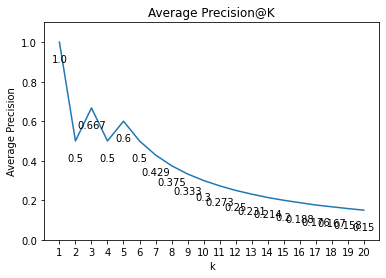

In [16]:
#Average precision@K
#k=rank 추천받을 사람 수
#rel=3개 지수가 만든 저자 목록에 전문가지수가 만든 저자가 포함 되어있다면 1, 아니라면 0
#m+사용자가 추천받은 것들 중 만족한 개수
import matplotlib.pyplot as plt

# rel_list = score_list_s
rel_list = [1 if item in answer_list_s else 0 for item in score_list_s]
precision_list=[]
cnt_1=0
for k in range(rank):
    if rel_list[k]==1:
        cnt_1+=1

    precision_k=round(cnt_1/(k+1), 3)
    precision_list.append(precision_k)

k_list = list(range(1, rank + 1))

# 선 그래프 그리기
plt.plot(k_list, precision_list)
plt.ylim(0, 1.1)

for i in range(len(k_list)):
    plt.text(k_list[i], precision_list[i] - 0.1, str(precision_list[i]), ha='center')

print(precision_list)
plt.xticks(range(1, 21))

# 그래프 제목 설정
plt.title("Average Precision@K")

# x축, y축 라벨 설정
plt.xlabel("k")
plt.ylabel("Average Precision")

# 그래프 보여주기
plt.show()


[100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
89786
50
50
매칭된 저자: [85, 66, 67, 63, 92, 52, 100, 98, 69, 94, 55, 56, 89, 91, 97, 81, 57, 59, 54, 99, 65, 90, 82, 96, 88, 95, 78, 83, 79, 74, 64, 60, 61, 71, 80, 76, 73, 68, 58, 87, 93, 84, 77, 72, 86, 51, 53, 75, 62, 70]
[85, 151.0, 193.27229348928765, 224.77229348928765, 264.3945368320398, 284.510882808236, 320.1316015190382, 352.7982681857049, 374.56534468392016, 402.8621642763344, 418.76072972381826, 434.3815346802815, 458.432730424313, 482.3338381126976, 507.1617665192497, 527.4117665192497, 541.3568474199885, 555.5057829475082, 568.2178642693067, 591.1243073721229]
[100, 199.0, 260.831115850002

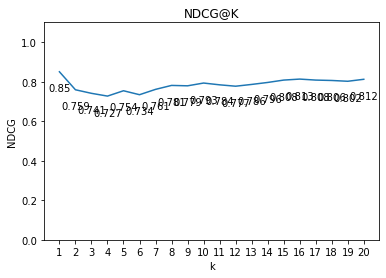

In [23]:
#NDCG@K
#NDCG=DCG/IDCG
import math
import numpy as np
i=0
# ideal_rel_rank_list = [i+1 for i in range(rank)]
ideal_rel_rank_list = [i+1 for i in range(100)]
ideal_rel_rank_list=ideal_rel_rank_list[::-1]
print(ideal_rel_rank_list)

rel_rank_list=[]
print(len(score_list_s))
print(len(answer_list_s))
for item in score_list_s:
    if item in answer_list_s:
        # print(item)
        result = np.where(answer_list_s == item)
        if len(result[0]) > 0:  # 조건을 만족하는 인덱스가 존재하는지 확인
            first_match_index = result[0][0]  # 첫 번째 매칭되는 인덱스
            rel_rank_list.append(ideal_rel_rank_list[first_match_index])  # 순위 추가
        else:
            rel_rank_list.append(0) 
    #     rel_rank_list.append(ideal_rel_rank_list[result])  # 순위 추가
    # else:
    #     rel_rank_list.append(0)  # 해당 항목이 answer_list에 없으면 0 추가

print(len(rel_rank_list))
print(f'매칭된 저자: {rel_rank_list}')

DCG_list = [0] * rank

for k in range(rank):
    # k=0일 때 log2(1)은 0이므로, 분모가 0이 되는 것을 방지
    if k > 0:
        DCG_list[k] = (rel_rank_list[k]/math.log2(k+1)) + DCG_list[k-1]
    else:
        DCG_list[k] = rel_rank_list[k]
print(DCG_list)

IDCG_list = [0] * rank

for k in range(rank):
    # k=0일 때 log2(1)은 0이므로, 분모가 0이 되는 것을 방지
    if k > 0:
        IDCG_list[k] = (ideal_rel_rank_list[k]/math.log2(k+1)) + IDCG_list[k-1]
    else:
        IDCG_list[k] = ideal_rel_rank_list[k]

print(IDCG_list)
NDCG_list=[0] * rank
for k in range(rank):
    NDCG_list[k]=round(DCG_list[k]/IDCG_list[k],3)
print(NDCG_list)

k_list = list(range(1, rank + 1))
print(NDCG_list)
# 선 그래프 그리기
plt.plot(k_list, NDCG_list)
plt.ylim(0, 1.1)

for i in range(len(k_list)):
    plt.text(k_list[i], NDCG_list[i] - 0.1, str(NDCG_list[i]), ha='center')

plt.xticks(range(1, 21))

# 그래프 제목 설정
plt.title("NDCG@K")

# x축, y축 라벨 설정
plt.xlabel("k")
plt.ylabel("NDCG")

# 그래프 보여주기
plt.show()